In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose


In [7]:
data_path = '../data/output.csv'

In [ ]:
df = pd.read_csv(data_path)
df.head()

,licencePlate,start_time,end_time,lat,lon,zipCode,fuelLevel,vehicleTypeId
0,bn32098,2025-07-21T17:37:29,2025-07-22T09:13:29,55.658398,12.514628,2500.0,72,2
1,bn32098,2025-07-22T09:17:29,2025-07-22T09:19:29,55.658348,12.515684,2500.0,73,2
2,bn32098,2025-07-22T09:23:29,2025-07-22T12:10:48,55.659286,12.519309,1805.0,72,2
3,bn32098,2025-07-22T14:24:49,2025-07-23T05:44:01,55.677685,12.522237,2000.0,71,2
4,bn32098,2025-07-23T15:46:01,2025-07-23T17:06:01,55.676945,12.520396,2000.0,50,2


#### Create a movement dataframe

In [ ]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df = df.sort_values(by=['licencePlate', 'start_time']).reset_index(drop=True)

# Create the movement DataFrame
movement_df = pd.DataFrame({
    'licencePlate': df['licencePlate'],
    'start_move_time': df['end_time'],
    'end_move_time': df['start_time'].shift(-1),
    'start_lat': df['lat'],
    'start_lon': df['lon'],
    'end_lat': df['lat'].shift(-1),
    'end_lon': df['lon'].shift(-1),
    'start_zip': df['zipCode'],
    'end_zip': df['zipCode'].shift(-1),
    'start_fuel': df['fuelLevel'],
    'end_fuel': df['fuelLevel'].shift(-1),
    'vehicleTypeId': df['vehicleTypeId']
})

# Remove the last row (no next record to compare)
movement_df = movement_df.iloc[:-1].copy()

movement_df['move_duration'] = movement_df['end_move_time'] - movement_df['start_move_time']
movement_df['fuel_used'] = movement_df['start_fuel'] - movement_df['end_fuel']

In [24]:
import pandas as pd

# Assuming df is your DataFrame
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Sort by car and time
df = df.sort_values(by=['licencePlate', 'start_time']).reset_index(drop=True)

# Do the shift within each car
df['next_start_time'] = df.groupby('licencePlate')['start_time'].shift(-1)
df['next_lat'] = df.groupby('licencePlate')['lat'].shift(-1)
df['next_lon'] = df.groupby('licencePlate')['lon'].shift(-1)
df['next_zip'] = df.groupby('licencePlate')['zipCode'].shift(-1)
df['next_fuel'] = df.groupby('licencePlate')['fuelLevel'].shift(-1)

# Build the movement dataframe
movement_df = df.copy()
movement_df['start_move_time'] = movement_df['end_time']
movement_df['end_move_time'] = movement_df['next_start_time']
movement_df['move_duration'] = movement_df['end_move_time'] - movement_df['start_move_time']
movement_df['fuel_used'] = movement_df['fuelLevel'] - movement_df['next_fuel']

# Keep only rows where we have a valid "next" record (i.e., same car)
movement_df = movement_df.dropna(subset=['end_move_time']).copy()

# Optional: rename columns for clarity
movement_df = movement_df.rename(columns={
    'lat': 'start_lat',
    'lon': 'start_lon',
    'zipCode': 'start_zip',
    'fuelLevel': 'start_fuel',
    'next_lat': 'end_lat',
    'next_lon': 'end_lon',
    'next_zip': 'end_zip',
    'next_fuel': 'end_fuel'
})

movement_df = movement_df[[
    'licencePlate', 'start_move_time', 'end_move_time',
    'start_lat', 'start_lon', 'end_lat', 'end_lon',
    'start_zip', 'end_zip', 'start_fuel', 'end_fuel',
    'move_duration', 'fuel_used', 'vehicleTypeId'
]]


In [25]:
movement_df.head(3)

,licencePlate,start_move_time,end_move_time,start_lat,start_lon,end_lat,end_lon,start_zip,end_zip,start_fuel,end_fuel,move_duration,fuel_used,vehicleTypeId
0,bn32098,2025-07-22 09:13:29,2025-07-22 09:17:29,55.658398,12.514628,55.658348,12.515684,2500.0,2500.0,72,73.0,0 days 00:04:00,-1.0,2
1,bn32098,2025-07-22 09:19:29,2025-07-22 09:23:29,55.658348,12.515684,55.659286,12.519309,2500.0,1805.0,73,72.0,0 days 00:04:00,1.0,2
2,bn32098,2025-07-22 12:10:48,2025-07-22 14:24:49,55.659286,12.519309,55.677685,12.522237,1805.0,2000.0,72,71.0,0 days 02:14:01,1.0,2


### Smoothing

In [71]:
movement_df['rental_minutes'] = (movement_df['end_move_time'] - movement_df['start_move_time']).dt.total_seconds() / 60

# Agregate total rent minutes per day
movement_df['date'] = movement_df['start_move_time'].dt.date
daily_use = movement_df.groupby('date')['rental_minutes'].sum().reset_index()

In [72]:
negative_trips = movement_df[movement_df['rental_minutes']<0]
negative_trips

,licencePlate,start_move_time,end_move_time,start_lat,start_lon,end_lat,end_lon,start_zip,end_zip,start_fuel,end_fuel,move_duration,fuel_used,vehicleTypeId,rental_minutes,date


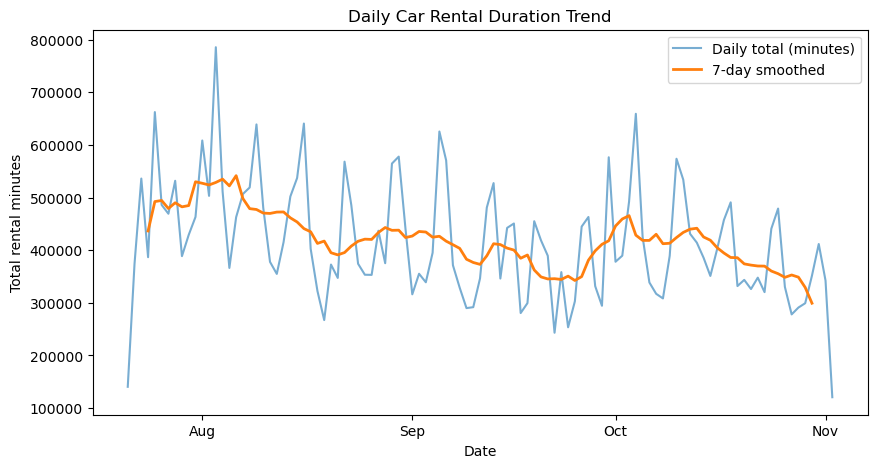

In [73]:
import matplotlib.dates as mdates

daily_use = daily_use.sort_values('date')

# For week analysis - 7-day window
daily_use['rental_minutes_smooth'] = daily_use['rental_minutes'].rolling(window=7, center=True).mean()

# Plot
plt.figure(figsize=(10,5))
plt.plot(daily_use['date'], daily_use['rental_minutes'], label='Daily total (minutes)', alpha=0.6)
plt.plot(daily_use['date'], daily_use['rental_minutes_smooth'], label='7-day smoothed', linewidth=2)

# Format x-axis to show months
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())       # one tick per month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # short month name, e.g. Jan, Feb

plt.xlabel('Date')
plt.ylabel('Total rental minutes')
plt.title('Daily Car Rental Duration Trend')
plt.legend()
plt.show()

### Decomposition

In [74]:
daily_use['date'] = pd.to_datetime(daily_use['date'])
daily_use = daily_use.sort_values('date')
daily_use = daily_use.set_index('date')
daily_use['total_hours'] = daily_use['rental_minutes']/60 

# Decompose
result = seasonal_decompose(
    #daily_use['rental_minutes'], 
    daily_use['total_hours'],
    model='additive', 
    period=7  # weekly pattern
)

/var/folders/cc/g293_qcj1hj4trkgsm21wwxr0000gn/T/ipykernel_24865/3127819632.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


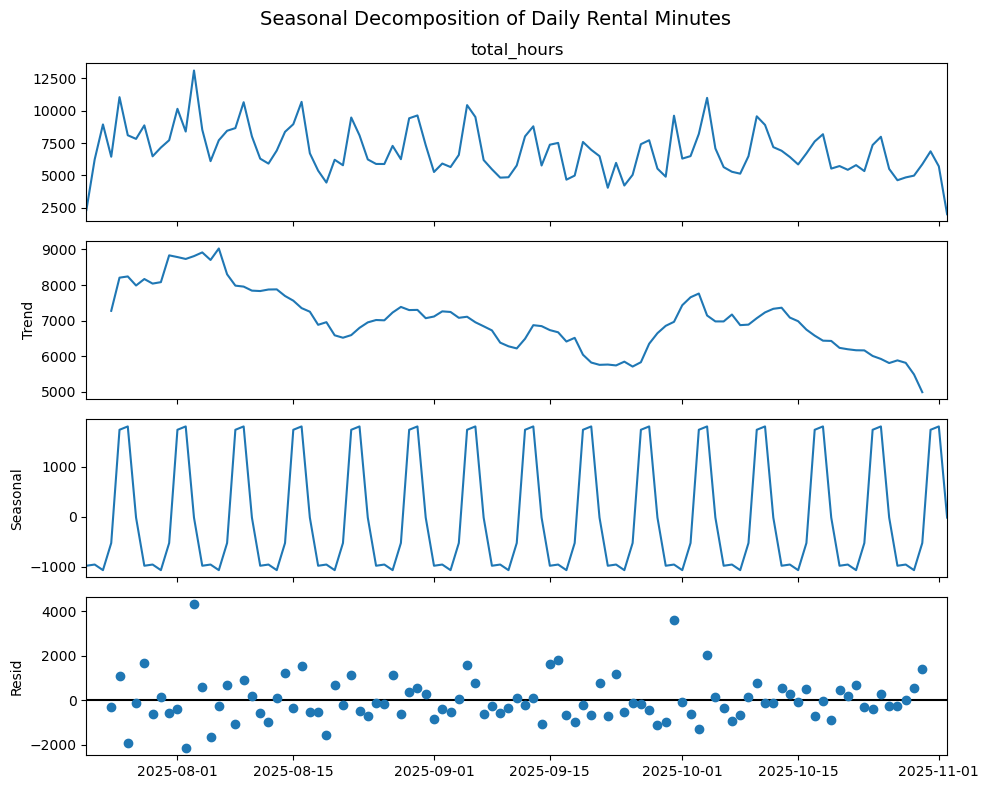

In [75]:
fig = result.plot()
fig.set_size_inches(10, 8)
plt.suptitle('Seasonal Decomposition of Daily Rental Minutes', fontsize=14)
plt.tight_layout()
plt.show()


In [76]:
# Extract components
trend = result.trend
seasonal = result.seasonal
resid = result.resid
observed = result.observed

denoised = trend + seasonal
detrended = observed - trend 

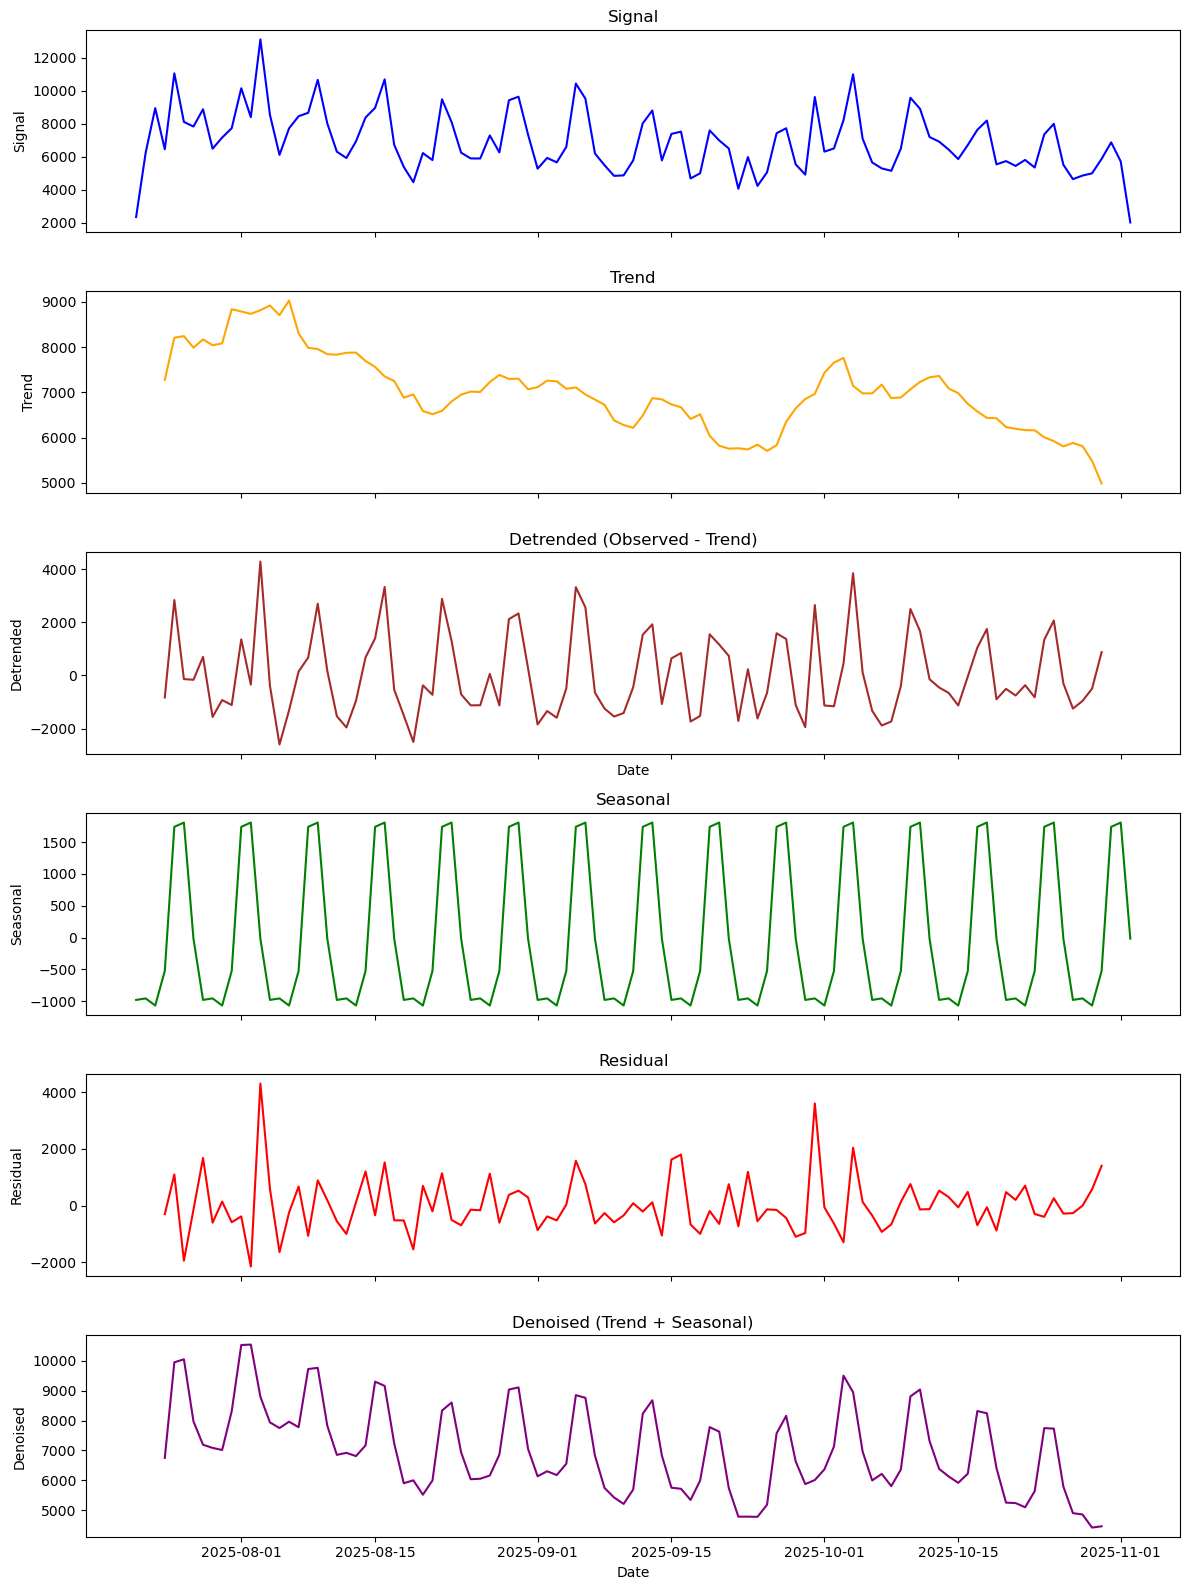

In [77]:
# Plot
fig, axes = plt.subplots(6, 1, figsize=(12, 16), sharex=True)

# Observed
axes[0].plot(observed.index, observed, color='blue')
axes[0].set_ylabel('Signal')
axes[0].set_title('Signal')

# Trend
axes[1].plot(trend.index, trend, color='orange')
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend')

# Detrended (Signal - Trend)
axes[2].plot(detrended.index, detrended, color='brown')
axes[2].set_ylabel('Detrended')
axes[2].set_title('Detrended (Observed - Trend)')
axes[2].set_xlabel('Date')

# Seasonal
axes[3].plot(seasonal.index, seasonal, color='green')
axes[3].set_ylabel('Seasonal')
axes[3].set_title('Seasonal')

# Residual
axes[4].plot(resid.index, resid, color='red')
axes[4].set_ylabel('Residual')
axes[4].set_title('Residual')

# Denoised (Trend + Seasonal)
axes[5].plot(denoised.index, denoised, color='purple')
axes[5].set_ylabel('Denoised')
axes[5].set_title('Denoised (Trend + Seasonal)')
axes[5].set_xlabel('Date')

plt.tight_layout()
plt.show()
